In [8]:
# Import the neede libraries
import qiskit
from qiskit import IBMQ
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit import QuantumCircuit, execute, Aer
from qiskit.tools.visualization import plot_histogram
from math import pi as pi
import math

In [11]:
# Load the IBM Quantum Account

MY_API_TOKEN = 'ddc5e3b0b256e5be3237daa8ba467c942e5277418d7f926a73ba99ad513a7b2e70ec780291ebcc096d2a64ff11209fd21ff462378a69a8f38ffc6b344c0ef968' 
IBMQ.save_account(MY_API_TOKEN, overwrite=True)
account = IBMQ.load_account()
print('Credentials loaded')

ibmqfactory.load_account:WARNING:2023-10-31 17:32:47,082: Credentials are already in use. The existing account in the session will be replaced.


Credentials loaded


In [12]:
# Get the provider and the backend
provider = IBMQ.get_provider(group='open')
backend = Aer.get_backend('qasm_simulator')

In [797]:
# Generate 3 random aplitudes for the initial state
amplitudes = []
for i in range(3):
    amplitudes.append(random.randint(1, 100))

choosen = (random.randint(0,2))

In [798]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, circuit_drawer
import random

# Create a quantum circuit with 3 qubits and 3 classical bits
d = QuantumRegister(3,'door')
c = ClassicalRegister(3, 'c')
qc = QuantumCircuit(d,c)

doors = [d0,d1,d2]
creg = [c_0,c_1,c_2]



# Initialize the state of the qubits to the desired probability distribution
sv = (amplitudes[0]*Statevector.from_label('001') + amplitudes[1]*Statevector.from_label('010') + amplitudes[2]*Statevector.from_label('100')) / math.sqrt(sum([x**2 for x in amplitudes]))
qc.initialize(sv.data, [0,1,2])


qc.measure(d[choosen],c[choosen])

probs = [round((int(y)**2)/(math.sqrt(sum([x**2 for x in amplitudes]))**2)*100,2) for y in amplitudes]
print(choosen)
print(probs)

0
[46.13, 38.24, 15.63]


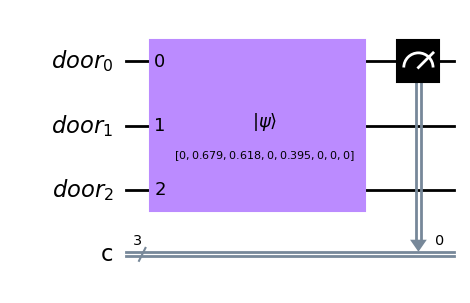

In [799]:
%matplotlib inline
qc.draw(output="mpl")

0
[46.13, 38.24, 15.63]
{'000': 70778, '001': 60294}


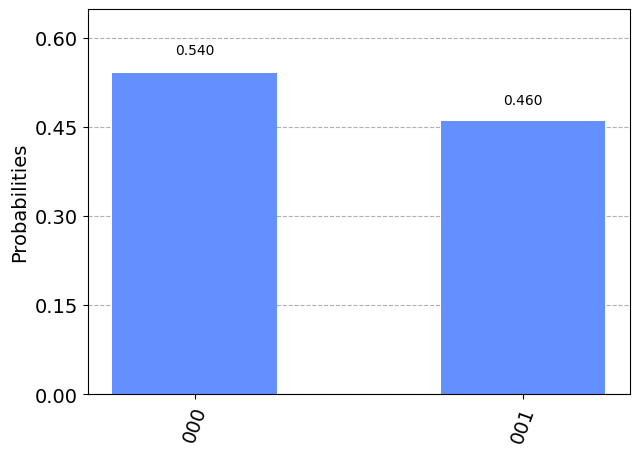

In [800]:
shots_n=1024*2**7
job = execute(qc, backend, shots=shots_n)
result = job.result()
counts = result.get_counts(qc)
print(choosen)
print(probs)
counts = result.get_counts(qc) 
print(counts)
plot_histogram(counts)

In [803]:
d = counts

total = 0
for key, value in d.items():
    if key[2-choosen] == '1':
        total += value

print(total/shots_n)

0.4600067138671875


In [804]:
print(probs)

[46.13, 38.24, 15.63]


# Classical Case of the Monty Hall Problem

## Initialization
We start by initializing three qubits in the $|0\rangle$ state, representing the three doors. The car is represented by the state $|1\rangle$ and the goats by the state $|0\rangle$.

In [1187]:
from qiskit import QuantumCircuit, QuantumRegister, execute, Aer
import numpy as np

# Create a quantum circuit with 3 qubits
q = QuantumRegister(3,'door')
c = ClassicalRegister(3, 'open')
qc = QuantumCircuit(q,c)

## Contestant Choice:
The contestant chooses a door, in this example, the door 0. This can be represented by initializing the first door to the state $\sqrt{\frac{2}{3}}|0\rangle+\frac{1}{\sqrt{3}}|1\rangle$

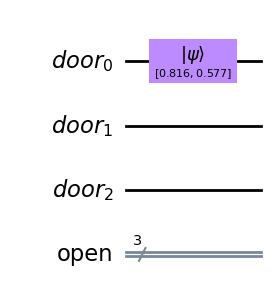

In [1188]:
# We prepare the state of the first door to the superposition state 
# where it has 1/3 chance of wining choosing the door 0.

init_state = [math.sqrt(2/3), math.sqrt(1/3)]
qc.initialize(init_state, 0)

%matplotlib inline
qc.draw(output="mpl")

# Host's Reveal:

The host, who knows what's behind each door, opens one of the other two doors to reveal a goat. This can be represented by applying  a $\text{CNOT}$ gate with the first qubit as control and one of the other two as targets after initializing them to state $|1\rangle$ (applying an $x$ gate to one the last two). This ensures that if the first qubit (the contestant's choice) is in state $|1\rangle$ (car), Then the other then one of the other qubits will be flipped to $|0\rangle$ (goat), simulating the host reveal.

The revealed door is door 2


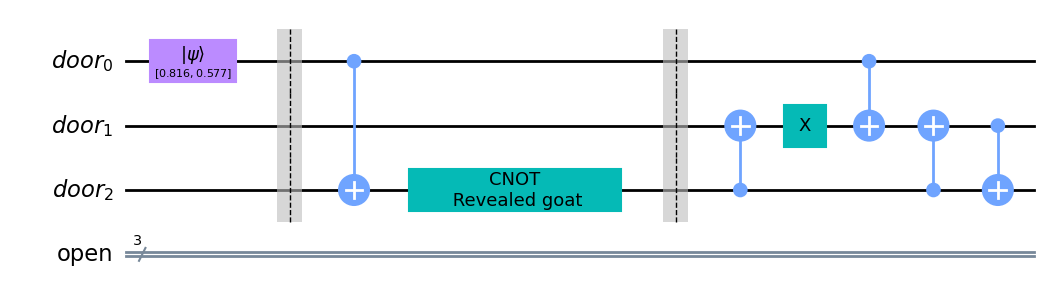

In [1189]:
revealed = 2 #random.randint(1,2)
print(f"The revealed door is door {revealed}")
qc.barrier()

# Apply a not CNOT gate followed by a NOT gate to the revealed door
qc.cx(q[0],q[revealed])
qc.x(q[revealed],label='CNOT\n Revealed goat')

# Apply a cnot gate using the revealed as control and the non choosen as target
for i in range(1,3):
    if i != revealed:
        qc.cx(q[revealed],q[i])
        qc.x(q[i])
        qc.cx(q[0],q[i])
        qc.cx(q[revealed],q[i])
        qc.cx(q[i],q[revealed])

%matplotlib inline
qc.draw(output="mpl")

# Contestant's Decision:

The contestant the has the option to stick with their original choice or switch to the other unopened door. This can be represented by applying a Hadamard gate to the first qubit again, effectively performing a quantum "switch".

0
[46.13, 38.24, 15.63]
{'110': 87093, '001': 43979}


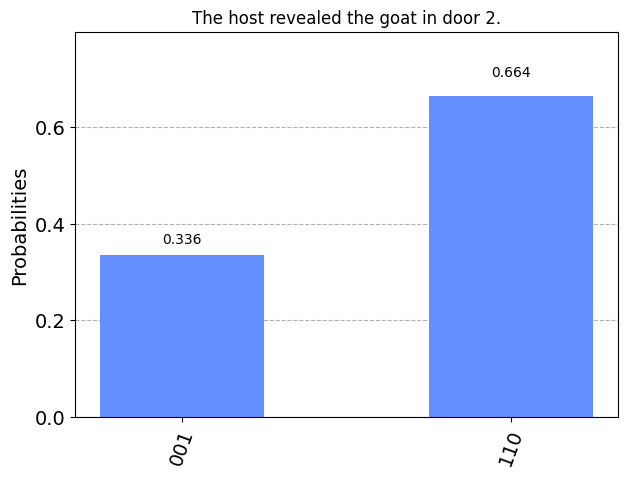

In [1184]:
qc.measure(q,c)
shots_n=1024*2**7
job = execute(qc, backend, shots=shots_n)
result = job.result()
counts = result.get_counts(qc)
print(choosen)
print(probs)
counts = result.get_counts(qc) 
print(counts)
plot_histogram(counts, title=f"The host revealed the goat in door {revealed}.")


In [1186]:
door = 0
d = counts

total = 0
for key, value in d.items():
    if key[2-door] == '1':
        total += value

print(total/shots_n)

0.33553314208984375


In [1121]:
print(list(range(1,3)))

[1, 2]
